# **Gaussian Processes Demo**  

_**A Walkthrough of Training and Evaluating Gaussian Process Models for the SLIPP Project**_

> Estimated reading time: 25-40 minutes
> 
> Author: Jakob Thoms
> 
> Date: June 2023

Soure code:
- [`/src/GaussianProcesses/models.py`](../src/GaussianProcesses/models.py)
- [`/src/GaussianProcesses/kernels.py`](../src/GaussianProcesses/kernels.py)
- [`/src/GaussianProcesses/utils.py`](../src/GaussianProcesses/utils.py)

Documentation:
- [`/docs/guides/GaussianProcesses/models.md`](../docs/guides/GaussianProcesses/models.md)
- [`/docs/guides/GaussianProcesses/kernels.md`](../docs/guides/GaussianProcesses/kernels.md)
- [`/docs/guides/GaussianProcesses/utils.md`](../docs/guides/GaussianProcesses/utils.md)


# TODO:
- References


## **Introduction**

<div class="alert alert-block alert-info">

#### **Background:**
**Previous research** has used ordinary least squares (OLS) linear regression to relate $\delta^{18}O$ to temperature (Stenni et al., 2017). We hope to improve and build upon these efforts.  

Assuming that we have a training data set with $n$ observations, let $y_i$ denote the $i\text{th}$ observed value of a specific climate variable (e.g. temperature
or precipitation), and let 
$$\mathbf{x}_i = \begin{pmatrix} \delta^{18}\text{O}_i\  \text{E}_{\text{UPS}, i}\  \text{N}_\text{UPS, i}\ \text{oro}_i \ d_{\text{coast}, i} \end{pmatrix}^\intercal \qquad (1)$$
denote the corresponding observed values of the ML model’s input variables (as prepared in the preprocessed dataset; see the preprocessing notebook for more details).

The OLS regression model relates the input variables in $\mathbf{x}$ to an output variable $y$ via a linear equation:

$$y_i = \beta_0 + \mathbf{\beta}^\intercal \mathbf{x}_i + \varepsilon_i \qquad (2)$$

In $(2)$, $\beta_0$ is a scalar, $\mathbf{\beta} = \begin{pmatrix} \beta_1\ \beta_2\ \beta_3\ \beta_4\ \beta_5\ \end{pmatrix}^\intercal$ is a vector of scalar coefficients, and $\varepsilon_i$ is a random variable. The parameter $\beta_0$ represents the linear model's intercept, and the parameters in $\mathbf{\beta}$ represent the linear model's slope with respect to each of the model's input variables. Further, the random variable $\varepsilon_i$ represents the model's error-term.  This term is assumed to be independently identically distributed as $\epsilon_i\sim\mathcal{N}(0,\sigma^2)$ for all $i = 1,\dots, n$, where $\sigma^2$ is the common variance of the error-terms.

The assumption of a linear relationship between input and output variables is quite restrictive in the sense that it does not allow for modelling complex non-linear relationships. Further, the independence assumption of OLS does not hold for climate data due to the spatial-temporal nature of such data. As such, we believe that better model performance† can be achieved by utilizing models that can accomodate both non-linearity and non-independence. (†performance as measured by various metrics; see the postprocessing notebook for more details).

**Gaussian Process** (GP) models were first introduced by Sacks et al. (1989). 
A GP model extends the OLS model in a way that removes the assumption of independence between observations while also
introducing some non-linearity within the model.
A GP model relates the input variables in $\mathbf{x}$ to an output variable $y$ via an equation quite similar to $(2)$ from OLS:

$$y_i = \beta_0 + \mathbf{\beta}^\intercal \mathbf{x}_i + Z(\mathbf{x}_i) \qquad (3)$$


In $(3)$, $\beta_0$ and $\mathbf{\beta}$ are the same as they were in $(2)$ (i.e. intercept and slopes). The random variable $\epsilon_i$ from $(2)$ has been replaced by a different random variable $Z(\mathbf{x}_i)$, and, as before, this stochastic term represents the model's error-term. However, this error-term $Z(\mathbf{x}_i)$ is **not** assumed to be independent for all $i = 1,\dots, n$. Instead, a GP model assumes that the error-terms follow an identical *marginal* distribution $Z(\mathbf{x}_i)\overset{\text{marginal}}{\sim}\mathcal{N}(0, \sigma^2)$ for all $i = 1,\dots, n$, where $\sigma^2$ is the common *marginal* variance of the error-terms (also known as the 'overall process variance'). 

Thus, the main difference between OLS models and GP models is in their correlation structure.
Whereas an OLS model assumes that 
$\text{Cor}(\varepsilon_i, \varepsilon_j) = 0 \text{ for }i \neq j,$
a GP model assumes that observations have a correlation structure which is determined by a kernel function $R(·\ ,\ ·)$:
$$\text{Cor}(Z(\mathbf{x}_i), Z(\mathbf{x}_j)) = R(\mathbf{x}_i, \mathbf{x}_j)\in[0,1] \qquad (4)$$
The kernel function models the correlation between observations as a function of their distance.
Although a GP has a linear regression component,
a kernel function can be non-linear, 
and as such GP models are capable of modelling non-linear relationships. 
There are many kernel functions available in the literature (Duvenaud 2014). 
For example, there are kernel functions which are able to directly model seasonal temporal correlation structures (Roberts et al. 2013). 
Thus, we dedicated a large amount of effort to selecting the most appropriate kernel functions.


#### **Implementation:**

For SLIPP 2023, Gaussian Process models were implemented with custom python classes which aim to streamline the use of `gpytorch` models. 

Several different default GP kernel configurations are provided.

The `GaussianProcesses.models.ExactGPModel` class is designed for the purpose of predicting climate data.
- It represents a Gaussian Process (GP) model using exact inference.
- It extends the `ExactGP` class from the `gpytorch` library.
- It allows the user to alter the mean regression component of the GP model to be constant rather than linear.
- It assumes that the model's input features are:
    - Column 0: Delta 18-O
    - Column 1: UPS Easting
    - Column 2: UPS Northing
    - Column 3: Orography
    - Column 4: Distance to Coast
    - Column 5: Month (as an integer from 1 to 12) (**OPTIONAL**)
    
The `GaussianProcesses.models.GP` class is designed for the purpose of exploring various GP model configurations with ease:
- It is a wrapper for storing all objects related to a `gpytorch` model.
- It implements a `.warmup(learning_rate, num_restarts, num_epochs_per_restart)` method:
    - This allows training with restarts to mitigate the effects of random hyperparameter initialization.
    - This method also prints informative messages while training (training progress, loss, etc.)
        - 'loss' refers to the GP model's negative marginal log likelihood. 
- It implements a `.train(learning_rate=0.1, num_epochs=5)` method:
    - This allows the user to easily train models using various different learning rates.
    - This method also prints informative messages while training (training progress, loss, etc.)
        - 'loss' refers to the GP model's negative marginal log likelihood. 
- It implements `.predict(X)` and `.get_posterior(X)` methods:
    - These allow the user to easily get predictions from trained models.

The `GaussianProcesses.kernels.get_kernel(config_id)` function is designed for the purpose of quickly initializing various pre-made GP kernel configurations with ease:
- It takes in a kernel ID, and returns the corresponding `gpytorch` kernel function.
- Each kernel ID corresponds to a specific kernel function and set of input features. The available kernel configurations are:
    - ID 0: RBFKernel + PeriodicKernel for month
    - ID 1: RBFKernel (deseasonalized variables; no month)
    - ID 2: PiecewisePolynomialKernel + PeriodicKernel for month
    - ID 3: PiecewisePolynomialKernel (deseasonalized variables; no month)
    - ID 4: RQKernel + PeriodicKernel for month
    - ID 5: RQKernel (deseasonalized variables; no month)
    - ID 7: SpectralMixtureKernel (deseasonalized variables; no month)
- These pre-made kernel configurations are designed specifically for preprocessed climate data with the following input features:
    - Column 0: Delta 18-O
    - Column 1: UPS Easting
    - Column 2: UPS Northing
    - Column 3: Orography
    - Column 4: Distance to Coast
    - Column 5: Month (as an integer from 1 to 12) [**Only required if the kernel ID is even**]
- Kernels with an even ID use the month feature as an input variable but do *not* deseasonalize the other variables.
- Kernels with an odd ID do *not* use the month feature as an input variable and instead deseasonalize the other variables.
- Kernel ID 6 does not exist because SpectralMixtureKernel cannot be combnined with PeriodicKernel.

Additional information on the `GPytorch` kernels:
- [RBFKernel](https://docs.gpytorch.ai/en/stable/kernels.html#rbfkernel)
- [PiecewisePolynomialKernel](https://docs.gpytorch.ai/en/stable/kernels.html#piecewisepolynomialkernel)
- [RQKernel](https://docs.gpytorch.ai/en/stable/kernels.html#rqkernel)
- [SpectralMixtureKernel](https://docs.gpytorch.ai/en/stable/kernels.html#spectralmixturekernel)
- [PeriodicKernel](https://docs.gpytorch.ai/en/stable/kernels.html#periodickernel)

##### Sockeye:

GP models are very computationally intensive because they compute pairwise distances between all training data points,
resulting in exploding space and time complexities on big data. This pairwise distance matrix must be stored as part
of the trained model to generate predictions.

The IsoGSM trainning dataset consists of nearly one million examples. GP models require a large amount of RAM in order to train on large datasets. Thus, access to cloud computing is required. The SLIPP 2023 MDS capstone project was completed using the computing resources provided by [UBC Arc Sockeye](https://arc.ubc.ca/ubc-arc-sockeye). Information about using Sockeye can be found here: 
- [SLIPP Sockeye Tutorial](https://github.com/SLIPP-isotopes/MDS_Antarctica/issues/31)
- [About Sockeye](https://confluence.it.ubc.ca/display/UARC/About+Sockeye)
- [Using Sockeye](https://confluence.it.ubc.ca/display/UARC/Using+Sockeye)
  
#### **Notebook Overview:** 


This notebook demonstrates how to use the code found in `src/GaussianProcesses/` at a basic level:
1. Load preprocessed training and validation data 
    - (prepared via the functions in `src/Preprocessing`; see the preprocessing notebook for more details)
2. Train GP models
3. Generate model predictions
4. Save predictions to disk
5. Calculate model Root Mean Squared Errors (RMSEs) and gererate residual plots 
    - (via the functions in `src/Postprocessing`; see the postprocessing notebook for more details)

For demonstrative purposes, two distinct GP models will be created in this notebook. Both models will predict temperature. 

The first GP model created (using kernel 1): 
- Does not include `month` as an input feature. Instead, it deseasonlizes the input/output variables. 
- Uses an `RBFKernel` for the variables Delta 18-O, UPS-Easting, UPS-Northing, Orographpy, and Distance to Coast.

The second GP model created (using kernel 0): 
- Does not deseasonlize the input/output variables. Instead, it includes `month` as an input feature.
- Uses an `RBFKernel` for the variables Delta 18-O, UPS-Easting, UPS-Northing, Orographpy, and Distance to Coast.
- Uses a `PeriodicKernel` for month.


#### **Purpose:** 

What is NOT intended: 
- The purpose of this notebook is not to generate the final Gaussian Process model predictions for the SLIPP 2023 MDS capstone project.
- This notebook is also not intended to be used as a skeleton in which to generate final outputs in your own project. 

What IS intended: 
- Demonstrate how to use the classes and functions in `src/GaussianProcesses/`.
- Explain how GP model configurations can be altered as well as why one may want to use certain configurations:
    - Kernel functions 
    - Regression component (linear vs. constant)
    - Model inputs
- Demonstrate what GP model outputs may look like. 
- Justify coding and modelling choices that were made when implementing these classes and functions. 
- After reading through this notebook, one could create their own notebook, copying bits of code from this demo notebook into their new notebook, and modify according to specific needs.
    - Alternatively, one could follow the [Gaussian Processes Command Line Tutorial](../docs/guides/GaussianProcesses/main.md) to train GP models and generate predictions via command line.
- After reading through this notebook, the user should be able to understand all of the code contained within the `main()` function of [`src/GaussianProcesses/scripts/gp_main.py`](../src/GaussianProcesses/scripts/gp_main.py).
     
##### Examples:
Throughout this notebook, there will be code cells which begin with the line `# EX:`. These code cells will are intended to show examples of what the variables / objects look like. These code cells do not run any computations and can be skipped. They simply print outputs to the screen. They are only for demonstative purposes to help the reader understand the intermediate variables in the notebook.
```python
# EX:

print(dataframe)
```

</div>

## **Demo**

<div class="alert alert-block alert-warning">

**Sections:**

0. Imports
1. Load and Wrangle Preprocessed Data
2. Initialize and Train Models
    - Train a GP model
    - Train another GP model
3. Generate Model Predictions
4. Save Trained Model Parameters and Predictions
5. Postprocessing / Evaluation
    - RMSEs
    - Residual Plots
    - Time-series Plots of Predictions

</div>

### 0. Imports

In [1]:
# External packages

import xarray as xr
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import gpytorch 
import warnings # For supressing warnings  
from IPython.display import Markdown # For displaying titles 

In [2]:
# SLIPP 2023

# Access the code in the `src/` directory while in the `notebooks/` directory 
import sys 
sys.path.append('../src/') 

# Move the current working directory to the top level directory
import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../') 

import GaussianProcesses.models
import GaussianProcesses.kernels
import GaussianProcesses.utils

### 1. Load and Wrangle Preprocessed Data

The classes in `src/GaussianProcesses` require the training and validation data to be preprocessed via the SLIPP 2023 preprocessing pipeline. To initialize and train a GP model, the user must provide a preprocessed XArray dataset which has been obtained using the code found in `src/Preprocessing`. See the preprocessing notebook for more details. This demo assumes that the user has used the code in `src/Preprocessing` to save netCDF files of preprocessed data to their local computer, and hence the demo begins by loading the preprocessed netCDF files as xarray datasets (via `xr.open_dataset()`). 

**You can modify the path/file names if necessary.**

---

Before running the following cell, ensure that you have the following files saved under the `MDS_Antarctica/data/` directory within your local clone of the GitHub repository: 
- `preprocessed_train_ds.nc`
- `preprocessed_valid_ds.nc`

To obtain these files, you can either: 
- Run the preprocessing script/notebook (if you have the raw IsoGSM data file)
- Transfer/download the preprocessed data from sockeye (if you have access to Sockeye, see [README.md](../README.md#2-downloading-data))
- Get the preprocessed data files from a previous member of the project

In [3]:
############ ENSURE THE PATH BELOW POINTS TO THE PREPROCESSED DATA 
data_dir = '../data/' 
################################################################## 

#### Wrangle data for GP models:    

The available options for `OUTPUT_VAR_ID` are:
- 0: `hgtprs` (Geopotential Height)
- 1: `pratesfc` (Precipitation Rate on the Surface)
- 2: `tmp2m` (Temperature 2m above surface)

In [4]:
# Feel free to change this
OUTPUT_VAR_ID = 2

In [5]:
# Load and wrangle training/validation data for GP kernel 0 
wrangled_data_k0 = GaussianProcesses.utils.wrangle(
    data_dir=data_dir, 
    output_var=OUTPUT_VAR_ID, 
    kernel_config_id=0
)

In [6]:
# EX:

train_X_no_nans, train_Y_no_nans_flat, \
valid_X_no_nans, valid_Y_no_nans_flat, \
valid_Y, valid_ds, valid_nan_mask, output_feat_name = wrangled_data_k0

display(pd.DataFrame(
    train_X_no_nans, 
    columns=[
        'scaled_d18O_pr', 
        'scaled_E', 
        'scaled_N', 
        'scaled_oro', 
        'scaled_dist_to_coast', 
        'month'
    ]
))

,scaled_d18O_pr,scaled_E,scaled_N,scaled_oro,scaled_dist_to_coast,month
0,-1.122642,-1.062303e-18,0.120476,0.992988,1.038808,1.0
1,-1.122642,3.941863e-03,0.120411,0.997805,1.046049,1.0
2,-1.122642,7.879506e-03,0.120218,1.002751,1.053424,1.0
3,-1.122642,1.180871e-02,0.119896,1.007820,1.060924,1.0
4,-1.122642,1.572527e-02,0.119445,1.013009,1.068538,1.0
...,...,...,...,...,...,...
898555,1.224560,-3.856311e-01,2.335733,-1.013657,-1.756939,12.0
898556,1.236955,-3.090016e-01,2.347100,-0.993787,-1.756939,12.0
898557,1.236955,-2.320412e-01,2.355954,-0.979766,-1.756939,12.0
898558,1.261901,-1.548323e-01,2.362284,-0.981723,-1.756939,12.0


In [7]:
# Load and wrangle training/validation data for GP kernel 1
wrangled_data_k1 = GaussianProcesses.utils.wrangle(
    data_dir=data_dir, 
    output_var=OUTPUT_VAR_ID, 
    kernel_config_id=1
)

In [8]:
# EX:

train_X_no_nans, train_Y_no_nans_flat, \
valid_X_no_nans, valid_Y_no_nans_flat, \
valid_Y, valid_ds, valid_nan_mask, output_feat_name = wrangled_data_k1

display(pd.DataFrame(
    train_Y_no_nans_flat, 
    columns=[output_feat_name]
))

,scaled_deseas_tmp2m
0,-1.517531
1,-1.517531
2,-1.517531
3,-1.517531
4,-1.517531
...,...
898555,0.095268
898556,0.054710
898557,0.054710
898558,0.022129


#### Reduce training data size:

Training a GP model using the entire IsoGSM training dataset would take over 3000 GB of RAM. Ideally, one would want to train the GP model using the entire training dataset, but due to these memory limitations, we must split up the training dataset. 

We need to make a decision regarding how many splits of training data to create:

When training with cloud computing, it is feasible to train a GP model on larger amounts of training data, and as such fewer splits are required. For example, we trained GP models using kernel 0 on splits consisting of 1/8th of the training dataset, and doing so required less than 186 GB of RAM. 

On the other hand, most personal computers have at most 16 GB of RAM, and as such they are not capable of training GP models on large amounts of data. Thus, many more splits are required. This can dramatically reduce the performance of the GP model. 

In practice, one would always use cloud computing for training GP models on climate data. We provide this notebook for demonstrative purposes. 


In [9]:
# Feel free to change these values:
TRAIN_SPLIT_N = 100 # The number of splits of the training dataset.
TRAIN_SPLIT_ID = 6 # The ID of the current split used for training (integer between 0 and TRAIN_SPLIT_N - 1)

In [10]:
train_X_no_nans_k0, train_Y_no_nans_flat_k0 = wrangled_data_k0[:2]

GP_train_data_k0_s6 = GaussianProcesses.utils.reduce_training_size(
    train_Y_no_nans_flat=train_Y_no_nans_flat_k0,
    train_X_no_nans=train_X_no_nans_k0,
    train_split_n=TRAIN_SPLIT_N, # total number of splits
    train_split_id=TRAIN_SPLIT_ID # integer between 0 and TRAIN_SPLIT_N - 1
)


	 182649 examples dropped during downscaling.

Training using examples with indices between 42954 (inclusive) and 50113 (exclusive)


In [11]:
train_X_no_nans_k1, train_Y_no_nans_flat_k1 = wrangled_data_k1[:2]

GP_train_data_k1_s6 = GaussianProcesses.utils.reduce_training_size(
    train_Y_no_nans_flat=train_Y_no_nans_flat_k1,
    train_X_no_nans=train_X_no_nans_k1,
    train_split_n=TRAIN_SPLIT_N, # total number of splits
    train_split_id=TRAIN_SPLIT_ID # integer between 0 and TRAIN_SPLIT_N - 1
)


	 182649 examples dropped during downscaling.

Training using examples with indices between 42954 (inclusive) and 50113 (exclusive)


In [12]:
# EX:

train_X_no_nans_split, train_Y_no_nans_flat_split = GP_train_data_k0_s6

display(pd.DataFrame(
    train_X_no_nans_split, 
    columns=[
        'scaled_d18O_pr', 
        'scaled_E', 
        'scaled_N', 
        'scaled_oro', 
        'scaled_dist_to_coast', 
        'month'
    ]
))

,scaled_d18O_pr,scaled_E,scaled_N,scaled_oro,scaled_dist_to_coast,month
0,-0.662703,1.356274,1.040706e+00,0.872295,0.447780,7.0
1,-0.893970,1.389599,9.957725e-01,0.989131,0.542798,7.0
2,-0.893970,1.421436,9.497730e-01,1.012661,0.629186,7.0
3,-0.893970,1.451750,9.027564e-01,0.923689,0.629186,7.0
4,-0.463633,1.480510,8.547731e-01,0.720393,0.530966,7.0
...,...,...,...,...,...,...
7154,0.211483,1.872368,1.719173e-16,-0.134255,0.290227,10.0
7155,0.211483,1.871366,-6.126218e-02,-0.062568,0.290227,10.0
7156,0.120345,1.868359,-1.224587e-01,-0.005126,0.290227,10.0
7157,0.120345,1.863352,-1.835242e-01,0.041079,0.290227,10.0


### 2. Initialize and Train Models

#### Choose GP kernel configuration:

The available options for `KERNEL_CONFIG_ID` are:
- 0: RBF + PeriodicKernel for month
- 1: RBF (deseasonalized; no month)
- 2: PiecewisePolynomialKernel + PeriodicKernel for month
- 3: PiecewisePolynomialKernel (deseasonalized; no month)
- 4: RQKernel + PeriodicKernel for month
- 5: RQKernel (deseasonalized; no month)
- 7: SpectralMixture (deseasonalized; no month)

In [13]:
kernel_0 = GaussianProcesses.kernels.get_kernel(config_id=0)
kernel_1 = GaussianProcesses.kernels.get_kernel(config_id=1)

In [14]:
# EX:

print(kernel_0)
print('-----')
print(*kernel_0.named_parameters_and_constraints())

ProductKernel(
  (kernels): ModuleList(
    (0): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (1): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
  )
)
-----
('kernels.0.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0.]], requires_grad=True), Positive()) ('kernels.1.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True), Positive()) ('kernels.1.raw_period_length', Parameter containing:
tensor([[12.0000]], requires_grad=True), Positive())


In [15]:
# EX:

print(kernel_1)
print('-----')
print(*kernel_1.named_parameters_and_constraints())

RBFKernel(
  (raw_lengthscale_constraint): Positive()
)
-----
('raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0.]], requires_grad=True), Positive())


#### Create the GP Model Object:

See the [guide for GaussianProcesses.models](../docs/guides/GaussianProcesses/models.md) for more detailed info. 

In [16]:
train_X_no_nans_k0_s6, train_Y_no_nans_flat_k0_s6 = GP_train_data_k0_s6

GP_model_k0 = GaussianProcesses.models.GP(
    model=GaussianProcesses.models.ExactGPModel, 
    likelihood=gpytorch.likelihoods.GaussianLikelihood,
    train_X=train_X_no_nans_k0_s6, # Training inputs 
    train_Y=train_Y_no_nans_flat_k0_s6, # Training outputs 
    mean='linear', # Can use either a linear or a constant mean (the regression component)
    kernel=kernel_0, # Use the kernel we created above (the covariance component)
)

In [17]:
train_X_no_nans_k1_s6, train_Y_no_nans_flat_k1_s6 = GP_train_data_k1_s6

GP_model_k1 = GaussianProcesses.models.GP(
    model=GaussianProcesses.models.ExactGPModel, 
    likelihood=gpytorch.likelihoods.GaussianLikelihood,
    train_X=train_X_no_nans_k1_s6, # Training inputs 
    train_Y=train_Y_no_nans_flat_k1_s6, # Training outputs 
    mean='linear', # Can use either a linear or a constant mean (the regression component)
    kernel=kernel_1, # Use the kernel we created above (the covariance component)
)

In [18]:
# EX:

# Initial model hyperparameters
# The mean module's initial parameter values (the slopes and intercept) are random 
print(*GP_model_k0.model.mean_module.named_parameters())
print('---')
print(*GP_model_k0.model.covar_module.named_parameters())

('weights', Parameter containing:
tensor([[ 0.2420],
        [ 0.2946],
        [-1.0386],
        [-0.0365],
        [-0.3378]], requires_grad=True)) ('bias', Parameter containing:
tensor([-1.4549], requires_grad=True))
---
('kernels.0.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0.]], requires_grad=True)) ('kernels.1.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True)) ('kernels.1.raw_period_length', Parameter containing:
tensor([[12.0000]], requires_grad=True))


We can reinitialize the model from scratch using the `.initialize_model()` method: 

In [19]:
GP_model_k0.initialize_model(
    GP_model_k0.initial_model, 
    GP_model_k0.initial_likelihood, 
    **GP_model_k0.initial_kwargs
)

Notice that the mean module's initial parameter values (the slopes and intercept) are random:

In [20]:
# EX:

# Initial model hyperparameters
print(*GP_model_k0.model.mean_module.named_parameters())
print('---')
print(*GP_model_k0.model.covar_module.named_parameters())

('weights', Parameter containing:
tensor([[ 0.9083],
        [-0.1162],
        [-0.4798],
        [-0.3558],
        [-0.2993]], requires_grad=True)) ('bias', Parameter containing:
tensor([0.2461], requires_grad=True))
---
('kernels.0.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0.]], requires_grad=True)) ('kernels.1.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True)) ('kernels.1.raw_period_length', Parameter containing:
tensor([[12.0000]], requires_grad=True))


#### Train the GP Model:

In [21]:
# Feel free to change this
LEARNING_RATE = 0.005

Verbose outputs will be of the form 
```bash
Loss: 1.376   noise: 0.693
```

- `Loss` refers to the GP model's negative marginal log likelihood. 
- `noise` refers to the GP model's overall process variance (i.e. the $\sigma^2$ term).

##### Warmups: 

The `GaussianProcesses.models.GP` class supports warmup training with restarts. This helps to mitigate the effects of random initial hyperparameter values.

In [22]:
# Feel free to change these values
NUM_RESTARTS = 3
NUM_EPOCHS_PER_RESTART = 5

In [23]:
GP_model_k0.warmup(
    num_restarts=NUM_RESTARTS, 
    num_epochs_per_restart=NUM_EPOCHS_PER_RESTART, 
    learning_rate=LEARNING_RATE
)

Restart 1/3, Epoch 1/5:
	 Loss: 0.843   noise: 0.693
--
Restart 1/3, Epoch 2/5:


	 Loss: 0.841   noise: 0.691
--
Restart 1/3, Epoch 3/5:
	 Loss: 0.839   noise: 0.688
--
Restart 1/3, Epoch 4/5:
	 Loss: 0.835   noise: 0.686
--
Restart 1/3, Epoch 5/5:
	 Loss: 0.834   noise: 0.683
--
===
Restart 2/3, Epoch 1/5:
	 Loss: 0.835   noise: 0.693
--
Restart 2/3, Epoch 2/5:
	 Loss: 0.838   noise: 0.691
--
Restart 2/3, Epoch 3/5:
	 Loss: 0.830   noise: 0.688
--
Restart 2/3, Epoch 4/5:
	 Loss: 0.829   noise: 0.686
--
Restart 2/3, Epoch 5/5:
	 Loss: 0.828   noise: 0.683
--
===
Restart 3/3, Epoch 1/5:
	 Loss: 0.836   noise: 0.693
--
Restart 3/3, Epoch 2/5:
	 Loss: 0.833   noise: 0.691
--
Restart 3/3, Epoch 3/5:
	 Loss: 0.829   noise: 0.688
--
Restart 3/3, Epoch 4/5:
	 Loss: 0.828   noise: 0.686
--
Restart 3/3, Epoch 5/5:
	 Loss: 0.825   noise: 0.683
--
===


In [24]:
GP_model_k1.warmup(
    num_restarts=NUM_RESTARTS, 
    num_epochs_per_restart=NUM_EPOCHS_PER_RESTART, 
    learning_rate=LEARNING_RATE
)

Restart 1/3, Epoch 1/5:


	 Loss: 1.422   noise: 0.693
--
Restart 1/3, Epoch 2/5:
	 Loss: 1.418   noise: 0.696
--
Restart 1/3, Epoch 3/5:
	 Loss: 1.420   noise: 0.698
--
Restart 1/3, Epoch 4/5:
	 Loss: 1.419   noise: 0.701
--
Restart 1/3, Epoch 5/5:
	 Loss: 1.417   noise: 0.703
--
===
Restart 2/3, Epoch 1/5:
	 Loss: 1.430   noise: 0.693
--
Restart 2/3, Epoch 2/5:
	 Loss: 1.431   noise: 0.696
--
Restart 2/3, Epoch 3/5:
	 Loss: 1.430   noise: 0.698
--
Restart 2/3, Epoch 4/5:
	 Loss: 1.429   noise: 0.701
--
Restart 2/3, Epoch 5/5:
	 Loss: 1.430   noise: 0.703
--
===
Restart 3/3, Epoch 1/5:
	 Loss: 1.426   noise: 0.693
--
Restart 3/3, Epoch 2/5:
	 Loss: 1.425   noise: 0.696
--
Restart 3/3, Epoch 3/5:
	 Loss: 1.424   noise: 0.698
--
Restart 3/3, Epoch 4/5:
	 Loss: 1.426   noise: 0.701
--
Restart 3/3, Epoch 5/5:
	 Loss: 1.422   noise: 0.703
--
===


In [25]:
# EX:

# Trained model hyperparameters (kernel 0)
print(*GP_model_k0.model.mean_module.named_parameters())
print('---')
print(*GP_model_k0.model.covar_module.named_parameters())

('weights', Parameter containing:
tensor([[ 1.2090],
        [-0.4013],
        [-0.4392],
        [-0.7260],
        [-1.1958]], requires_grad=True)) ('bias', Parameter containing:
tensor([-0.1966], requires_grad=True))
---
('kernels.0.raw_lengthscale', Parameter containing:
tensor([[0.0749, 0.0748, 0.0749, 0.0749, 0.0749]], requires_grad=True)) ('kernels.1.raw_lengthscale', Parameter containing:
tensor([[0.0749]], requires_grad=True)) ('kernels.1.raw_period_length', Parameter containing:
tensor([[12.0749]], requires_grad=True))


##### Training: 

In [26]:
# Feel free to change this
NUM_EPOCHS = 20

In [27]:
GP_model_k0.train(
    num_epochs=NUM_EPOCHS - NUM_EPOCHS_PER_RESTART, 
    learning_rate=LEARNING_RATE
)

Epoch 6/20:


	 Loss: 0.822   noise: 0.681
--
Epoch 7/20:
	 Loss: 0.822   noise: 0.678
--
Epoch 8/20:
	 Loss: 0.819   noise: 0.676
--
Epoch 9/20:
	 Loss: 0.815   noise: 0.673
--
Epoch 10/20:
	 Loss: 0.812   noise: 0.671
--
Epoch 11/20:
	 Loss: 0.811   noise: 0.669
--
Epoch 12/20:
	 Loss: 0.808   noise: 0.666
--
Epoch 13/20:
	 Loss: 0.806   noise: 0.664
--
Epoch 14/20:
	 Loss: 0.805   noise: 0.661
--
Epoch 15/20:
	 Loss: 0.801   noise: 0.659
--
Epoch 16/20:
	 Loss: 0.798   noise: 0.656
--
Epoch 17/20:
	 Loss: 0.796   noise: 0.654
--
Epoch 18/20:
	 Loss: 0.794   noise: 0.652
--
Epoch 19/20:
	 Loss: 0.789   noise: 0.649
--
Epoch 20/20:
	 Loss: 0.788   noise: 0.647
--


In [28]:
GP_model_k1.train(
    num_epochs=NUM_EPOCHS - NUM_EPOCHS_PER_RESTART, 
    learning_rate=LEARNING_RATE
)

Epoch 6/20:


	 Loss: 1.415   noise: 0.706
--
Epoch 7/20:
	 Loss: 1.416   noise: 0.708
--
Epoch 8/20:
	 Loss: 1.414   noise: 0.711
--
Epoch 9/20:
	 Loss: 1.416   noise: 0.713
--
Epoch 10/20:
	 Loss: 1.417   noise: 0.716
--
Epoch 11/20:
	 Loss: 1.414   noise: 0.718
--
Epoch 12/20:
	 Loss: 1.414   noise: 0.721
--
Epoch 13/20:
	 Loss: 1.410   noise: 0.723
--
Epoch 14/20:
	 Loss: 1.409   noise: 0.726
--
Epoch 15/20:
	 Loss: 1.410   noise: 0.728
--
Epoch 16/20:
	 Loss: 1.410   noise: 0.730
--
Epoch 17/20:
	 Loss: 1.409   noise: 0.732
--
Epoch 18/20:
	 Loss: 1.410   noise: 0.734
--
Epoch 19/20:
	 Loss: 1.410   noise: 0.736
--
Epoch 20/20:
	 Loss: 1.407   noise: 0.738
--


### 3. Generate Model Predictions



In [29]:
# Get validation data from the `wrangled_data_k*` tuples that we created in step (1)

valid_X_no_nans_k1, valid_Y_no_nans_flat_k1, valid_Y_k1, \
valid_ds, valid_nan_mask, output_feat_name = wrangled_data_k1[2:]

valid_X_no_nans_k0, valid_Y_no_nans_flat_k0, valid_Y_k0, = wrangled_data_k0[2:5] # valid_ds, valid_nan_mask, and output_feat_name are the same for both models.

output_feat_name = output_feat_name.split("_")[-1] # Strip away any tags (e.g. 'scaled_')

In [30]:
# EX: 

print(output_feat_name)

tmp2m


We have to split up the validation predictions into batches to run locally. Once again, this is due to memory constraints associated with GP models. 

In [31]:
# Feel free to change this
NUM_VALID_BATCHES = 100

valid_batch_size = valid_X_no_nans_k1.size()[0] // NUM_VALID_BATCHES

We can use the `.predict(X)` method of the `GP` class to easily get predictions.

We can also use the `.get_posterior(X)` to obtain the posterior distribution (a multivariate normal distribution).

In [32]:
# EX:

# Get a slice of the validation data (create the 'batch')
i = 1
start_index = i * valid_batch_size
end_index = (i + 1) * valid_batch_size
valid_batch = valid_X_no_nans_k1[start_index:end_index]
    
# Get predictions on the validation batch
valid_batch_pred = GP_model_k1.predict(valid_batch)

# Get posterior distribution given the validation batch
valid_batch_post = GP_model_k1.get_posterior(valid_batch)


print(type(valid_batch_pred))
print(valid_batch_pred[:5])
print()
print(type(valid_batch_post))
print(valid_batch_post.covariance_matrix[:5, :5])
print()
print(   # Predictions are equal to the mean of the posterior:
    sum(valid_batch_pred != valid_batch_post.mean)
)

<class 'torch.Tensor'>
tensor([0.1922, 0.1837, 0.1521, 0.0885, 0.0283])

<class 'gpytorch.distributions.multivariate_normal.MultivariateNormal'>
tensor([[1.1851, 0.4833, 0.4749, 0.4653, 0.4377],
        [0.4833, 1.2988, 0.5600, 0.5778, 0.5548],
        [0.4749, 0.5600, 1.3118, 0.6008, 0.5882],
        [0.4653, 0.5778, 0.6008, 1.3977, 0.6560],
        [0.4377, 0.5548, 0.5882, 0.6560, 1.4057]])

tensor(0)


The code in the next two cells loops over all validation batches to generate predictions and then concatenates all the predictions together. 

While doing so, it also generates predictions on validation datasets which have their delta values replaced with random values. This helps us to determine whether or not the GP models are actually using the delta values to improve their prediction accuracy.

These ideas are also implemented in `src/GaussianProcesses/scripts/gp_main.py`.

In [33]:
# Kernel 1

np.random.seed(2023)

valid_batch_preds_k1 = []
rand_uniform_batch_preds_k1 = []
rand_normal_batch_preds_k1 = []
print(f"Generating validation predictions in batches.\nUsing {NUM_VALID_BATCHES} batches.")
for i in range(NUM_VALID_BATCHES):

    # Print progress
    NUM_PRINTS = 5 # Feel free to change this.
    if i % (NUM_VALID_BATCHES // NUM_PRINTS) == 0:
        print(f"{round(i / NUM_VALID_BATCHES * 100)}% complete.")

    # Get a slice of the validation data (create the 'batch')
    start_index = i * valid_batch_size
    end_index = (i + 1) * valid_batch_size
    valid_batch = valid_X_no_nans_k1[start_index:end_index]
    if i == NUM_VALID_BATCHES - 1: # valid_X_no_nans_k1.size()[0] // NUM_VALID_BATCHES rounds down. 
        valid_batch = valid_X_no_nans_k1[start_index:] # Make sure we get predictions for every example!
        
    # Clone the validation batch and replace all
    #  delta values w/ random values ~ Unif(-1.5, 1.5)
    rand_uniform_batch = valid_batch.clone().detach()
   
    rand_uniform_batch[:, 0] = torch.tensor(    
        np.random.uniform(
            -1.5, 1.5, 
            size=rand_uniform_batch[:, 0].size()
        )
    )

    # Clone the validation batch and replace all
    #  delta values w/ random values ~ Normal(0, 1)
    rand_normal_batch = valid_batch.clone().detach()
    rand_normal_batch[:, 0] = torch.tensor(
        np.random.normal(
            0, 1, 
            size=rand_normal_batch[:, 0].size()
        )
    )

    # Get predictions on the validation batch (real data and randomized data)
    valid_batch_pred = GP_model_k1.predict(valid_batch)
    rand_uniform_batch_pred = GP_model_k1.predict(rand_uniform_batch)
    rand_normal_batch_pred = GP_model_k1.predict(rand_normal_batch)

    # Add the predictions from the current batch to the lists of all predictions
    valid_batch_preds_k1.append(valid_batch_pred)
    rand_uniform_batch_preds_k1.append(rand_uniform_batch_pred)
    rand_normal_batch_preds_k1.append(rand_normal_batch_pred)

print("100% complete.")

# Concatenate the lists of tensors into single tensors (real data and randomized data)
valid_preds_k1 = torch.cat(valid_batch_preds_k1, dim=0)
rand_uniform_preds_k1 = torch.cat(rand_uniform_batch_preds_k1, dim=0)
rand_normal_preds_k1 = torch.cat(rand_normal_batch_preds_k1, dim=0)

Generating validation predictions in batches.
Using 100 batches.
0% complete.


20% complete.
40% complete.
60% complete.
80% complete.
100% complete.


In [34]:
# Kernel 0
print(f"Generating validation predictions in batches.\nUsing {NUM_VALID_BATCHES} batches.")

np.random.seed(2023)

valid_batch_preds_k0 = []
rand_uniform_batch_preds_k0 = []
rand_normal_batch_preds_k0 = []
for i in range(NUM_VALID_BATCHES):

    # Print progress
    NUM_PRINTS = 5 # Feel free to change this.
    if i % (NUM_VALID_BATCHES // NUM_PRINTS) == 0:
        print(f"{round(i / NUM_VALID_BATCHES * 100)}% complete.")

    # Get a slice of the validation data (create the 'batch')
    start_index = i * valid_batch_size
    end_index = (i + 1) * valid_batch_size
    valid_batch = valid_X_no_nans_k0[start_index:end_index]
    if i == NUM_VALID_BATCHES - 1: # valid_X_no_nans_k0.size()[0] // NUM_VALID_BATCHES rounds down. 
        valid_batch = valid_X_no_nans_k0[start_index:] # Make sure we get predictions for every example!
        
    # Clone the validation batch and replace all
    #  delta values w/ random values ~ Unif(-1.5, 1.5)
    rand_uniform_batch = valid_batch.clone().detach()
   
    rand_uniform_batch[:, 0] = torch.tensor(    
        np.random.uniform(
            -1.5, 1.5, 
            size=rand_uniform_batch[:, 0].size()
        )
    )

    # Clone the validation batch and replace all
    #  delta values w/ random values ~ Normal(0, 1)
    rand_normal_batch = valid_batch.clone().detach()
    rand_normal_batch[:, 0] = torch.tensor(
        np.random.normal(
            0, 1, 
            size=rand_normal_batch[:, 0].size()
        )
    )

    # Get predictions on the validation batch (real data and randomized data)
    valid_batch_pred = GP_model_k0.predict(valid_batch)
    rand_uniform_batch_pred = GP_model_k0.predict(rand_uniform_batch)
    rand_normal_batch_pred = GP_model_k0.predict(rand_normal_batch)

    # Add the predictions from the current batch to the lists of all predictions
    valid_batch_preds_k0.append(valid_batch_pred)
    rand_uniform_batch_preds_k0.append(rand_uniform_batch_pred)
    rand_normal_batch_preds_k0.append(rand_normal_batch_pred)

print("100% complete.")

# Concatenate the lists of tensors into single tensors (real data and randomized data)
valid_preds_k0 = torch.cat(valid_batch_preds_k0, dim=0)
rand_uniform_preds_k0 = torch.cat(rand_uniform_batch_preds_k0, dim=0)
rand_normal_preds_k0 = torch.cat(rand_normal_batch_preds_k0, dim=0)

Generating validation predictions in batches.
Using 100 batches.
0% complete.


20% complete.
40% complete.
60% complete.
80% complete.
100% complete.


In [35]:
# EX:

print(valid_preds_k0[:10])
print(type(valid_preds_k0))

tensor([-2.7494, -2.7603, -2.7713, -2.7824, -2.7936, -2.8049, -2.8163, -2.8258,
        -2.8300, -2.8340])
<class 'torch.Tensor'>


Notice that the validation predictions are currently a flat `pytorch` tensor. We need to convert them back to `xarray`. This is tricky because we need to be careful that the each prediction ends up corresponding to the right latitude/longitude/time coordinate. 

This task is handled by the `GaussianProcesses.utils.flat_validation_predictions_to_xarray()` function:
- In order to properly convert the flat predictions back to `xarray`, it requires both:
    - the original `valid_ds` (an `xarray` dataset), and
    - the `valid_nan_mask` (a boolean mask indicating the location of NaN values in the flattened `valid_ds`)
- The function accepts the actual validation predictions as well as the predictions on the randomized deltas.
- The function returns one `xarray` dataset that contains all the predictions (both actual and randomized) as well as the true values. 
- The resulting `xarray` dataset will have new atttributes that specify the GP kernel ID, etc. 

In [36]:
valid_preds_ds_k0 = GaussianProcesses.utils.flat_validation_predictions_to_xarray(
    valid_preds_k0, rand_uniform_preds_k0, rand_normal_preds_k0,
    valid_Y_k0, valid_ds, valid_nan_mask, output_feat_name, 
    kernel_config_id=0, train_split_id=TRAIN_SPLIT_ID
)

valid_preds_ds_k1 = GaussianProcesses.utils.flat_validation_predictions_to_xarray(
    valid_preds_k1, rand_uniform_preds_k1, rand_normal_preds_k1,
    valid_Y_k1, valid_ds, valid_nan_mask, output_feat_name, 
    kernel_config_id=1, train_split_id=TRAIN_SPLIT_ID
)

In [37]:
# EX:

print(type(valid_preds_ds_k1))

var_names = [*valid_preds_ds_k1.variables]
display(var_names[-3:])

print(valid_preds_ds_k1.attrs['kernel_config_id'])

<class 'xarray.core.dataset.Dataset'>


['pred_scaled_deseas_tmp2m',
 'pred_scaled_deseas_tmp2m__uniform_random_deltas',
 'pred_scaled_deseas_tmp2m__normal_random_deltas']

1


For demonstration purposes, the following code cell shows dataframes with the actual and predicted y-values for side-by-side:

In [38]:
# EX:

# Kernel 1
gp_preds_df = valid_preds_ds_k1[['scaled_deseas_tmp2m', 'pred_scaled_deseas_tmp2m']].to_dataframe()
display(Markdown(
    '**Actual vs. Predicted Values for Temperature (Scaled Deseasonalized) [GP Kernel 1]**'
))
display(gp_preds_df)

# Kernel 0
gp_preds_df = valid_preds_ds_k0[['scaled_tmp2m', 'pred_scaled_tmp2m']].to_dataframe()
display(Markdown(
    '**Actual vs. Predicted Values for Temperature (Scaled) [GP Kernel 0]**'
))
display(gp_preds_df)

**Actual vs. Predicted Values for Temperature (Scaled Deseasonalized) [GP Kernel 1]**

scaled_deseas_tmp2m  \
time                latitude longitude                        
1987-01-16 09:00:00 -88.542  0.000                 0.752905   
                             1.875                 0.752905   
                             3.750                 0.752905   
                             5.625                 0.752905   
                             7.500                 0.752905   
...                                                     ...   
1994-12-16 09:00:00 -61.903  350.625               0.125032   
                             352.500               0.132468   
                             354.375               0.132468   
                             356.250               0.125552   
                             358.125               0.125552   

                                        pred_scaled_deseas_tmp2m  
time                latitude longitude                            
1987-01-16 09:00:00 -88.542  0.000                           NaN  
                             1.875                     -0.740006  
                             3.750                     -0.744684  
                             5.625                     -0.749318  
                             7.500                     -0.753893  
...                                                          ...  
1994-12-16 09:00:00 -61.903  350.625                    0.208403  
                             352.500                    0.542141  
                             354.375                    0.612429  
                             356.250                    0.511526  
                             358.125                    0.551413  

[276480 rows x 2 columns]

**Actual vs. Predicted Values for Temperature (Scaled) [GP Kernel 0]**

scaled_tmp2m  pred_scaled_tmp2m
time                latitude longitude                                 
1987-01-16 09:00:00 -88.542  0.000         -0.251807                NaN
                             1.875         -0.251807          -2.749384
                             3.750         -0.251807          -2.760256
                             5.625         -0.251807          -2.771260
                             7.500         -0.251807          -2.782382
...                                              ...                ...
1994-12-16 09:00:00 -61.903  350.625        1.393304           2.493778
                             352.500        1.394926           2.520707
                             354.375        1.394926           2.495983
                             356.250        1.393965           2.429541
                             358.125        1.393965           2.424494

[276480 rows x 2 columns]

### 4. Save Trained Model Parameters and Predictions

#### GP Output Filename Prefixes

For the SLIPP 2023 MDS capstone project, all GP model output files follow a common syntax for filename prefixes.

Any given output file will have a name of the following form:

```
{output_file_prefix}_filename
```

The `output_file_prefix `is specifed using the following format:

```
gp_{output_feat_name}_k{KERNEL_CONFIG_ID}_m{MEAN_ID}_n{TRAIN_SPLIT_N}_s{TRAIN_SPLIT_ID}_e{NUM_EPOCHS}_l{LEARNING_RATE}
```
- `output_feat_name`: The name of the output feature from the wrangled data.
- `KERNEL_CONFIG_ID`: The ID of the chosen kernel configuration.
- `MEAN_ID`: The ID of the chosen mean regression component.
- `TRAIN_SPLIT_N`: The number of splits (batches) in the training dataset.
- `TRAIN_SPLIT_ID`: The ID of the current split (batch) used for training.
- `NUM_EPOCHS`: The total number of epochs for training.
- `LEARNING_RATE`: The learning rate used for training.
- `PROCESSING_UNIT`: The processing unit used, either 'cpu' or 'gpu'.


(where `MEAN_ID = 0` for 'constant' mean component and `MEAN_ID = 1` for 'linear' mean component).

In previous code cells in this notebook we have already specified `output_feat_name`, `KERNEL_CONFIG_ID`, `TRAIN_SPLIT_N`, `TRAIN_SPLIT_ID`, `NUM_EPOCHS`, and `LEARNING_RATE`.

Recall we can use either a linear or a constant mean (the GP model's regression component). When we created the `GP` model in step (2), we specified `mean='linear'`. Hence `MEAN_ID = 1`. 

This notebook is setup to train the GP model using CPU. Hence `PROCESSING_UNIT = 'cpu'` 

In [39]:
MEAN_ID = 1 # We used a linear regression component
PROCESSING_UNIT = "cpu" # We trained on CPU

output_file_prefix_k1 = f"gp_{output_feat_name}_k{1}_m{MEAN_ID}_n{TRAIN_SPLIT_N}_s{TRAIN_SPLIT_ID}_e{NUM_EPOCHS}_l{LEARNING_RATE}_{PROCESSING_UNIT}"
output_file_prefix_k0 = f"gp_{output_feat_name}_k{0}_m{MEAN_ID}_n{TRAIN_SPLIT_N}_s{TRAIN_SPLIT_ID}_e{NUM_EPOCHS}_l{LEARNING_RATE}_{PROCESSING_UNIT}"

In [40]:
# EX:

print(output_file_prefix_k0)
print(output_file_prefix_k1)

gp_tmp2m_k0_m1_n100_s6_e20_l0.005_cpu
gp_tmp2m_k1_m1_n100_s6_e20_l0.005_cpu


#### Save data

The code below saves the trained GP model parameters as well as the datasets containing the GP model predictions to the directory specified by `output_dir`.

The saved model parameters can be used to load the trained model later on. The user could then make predictions on new data or continue to train the model for more epochs if desired.

The model predictions are saved in netCDF files that can be loaded easily later on to perform post-processing and evaluation.

In [41]:
############ EDIT THIS PATH IF NEEDED
output_dir = './demo_outputs/'
#####################################

##### Kernel 1

In [42]:
# Save trained model parameters
model_state_file_k1 = output_file_prefix_k1 + "_model_state.pth"
torch.save(GP_model_k1.model.state_dict(), output_dir + model_state_file_k1)

# Save GP model predictions as netCDF files 
preds_file_k1 = output_file_prefix_k1 + "_valid_preds.nc"
valid_preds_ds_k1.to_netcdf(path=output_dir + preds_file_k1)

##### Kernel 0

In [43]:
# Save trained model parameters
model_state_file_k0 = output_file_prefix_k0 + "_model_state.pth"
torch.save(GP_model_k0.model.state_dict(), output_dir + model_state_file_k0)

# Save GP model predictions as netCDF files 
preds_file_k0 = output_file_prefix_k0 + "_valid_preds.nc"
valid_preds_ds_k0.to_netcdf(path=output_dir + preds_file_k0)

In [44]:
# EX:

print(output_dir + model_state_file_k0)
print(output_dir + preds_file_k0)

./demo_outputs/gp_tmp2m_k0_m1_n100_s6_e20_l0.005_cpu_model_state.pth
./demo_outputs/gp_tmp2m_k0_m1_n100_s6_e20_l0.005_cpu_valid_preds.nc


### 5. Postprocessing / Evaluation

This section utilizes the `Postprocessing.utils` code to evaluate the predictions generated. See the postprocessing demo notebook for more details.


In [45]:
import Postprocessing.utils

First, the user must load the saved netCDF prediction files as `xarray` datasets:

In [46]:
# Load the predictions that we saved in step (4) 
gp_preds_ds_k1 = xr.open_dataset(output_dir + preds_file_k1)
gp_preds_ds_k0 = xr.open_dataset(output_dir + preds_file_k0)

#### Calculate Residuals

The following code uses `calculate_residuals()` from `Postprocessing.utils` to compute residuals from the validation predictions of the trained GP models.

This function calculates residuals in all possible variable output scales (see postprocessing guides for more info).

In [47]:
# Calculate residuals (in all possible variable scales) and
# add them to the dataset as new variables
gp_preds_ds_k1 = Postprocessing.utils.calculate_residuals(gp_preds_ds_k1)
gp_preds_ds_k0 = Postprocessing.utils.calculate_residuals(gp_preds_ds_k0)

In [48]:
# EX:

print(type(gp_preds_ds_k1))

var_names = [*gp_preds_ds_k1.variables]
display(var_names[-12:])

<class 'xarray.core.dataset.Dataset'>


['resid_tmp2m',
 'resid_scaled_tmp2m',
 'resid_deseas_tmp2m',
 'resid_scaled_deseas_tmp2m',
 'resid_tmp2m__uniform_random_deltas',
 'resid_scaled_tmp2m__uniform_random_deltas',
 'resid_deseas_tmp2m__uniform_random_deltas',
 'resid_scaled_deseas_tmp2m__uniform_random_deltas',
 'resid_tmp2m__normal_random_deltas',
 'resid_scaled_tmp2m__normal_random_deltas',
 'resid_deseas_tmp2m__normal_random_deltas',
 'resid_scaled_deseas_tmp2m__normal_random_deltas']

#### RMSEs

The following code uses `calculate_model_RMSE()` from `Postprocessing.utils` to compute the Root Mean Squared Error (RMSE) scores from the validation residuals of the trained GP models.

The `calculate_model_RMSE()` function always returns RMSE on the `scaled_deseas` output variable scale.

In [49]:
# Calculate RMSE of residuals (in scaled_deseas scale)
gp_RMSEs_k1 = Postprocessing.utils.calculate_model_RMSE(gp_preds_ds_k1)
gp_RMSEs_k0 = Postprocessing.utils.calculate_model_RMSE(gp_preds_ds_k0)

In [50]:
# EX:

display(gp_RMSEs_k1)
print('---')
display(gp_RMSEs_k0)

{'scaled_deseas_tmp2m': 1.3839251647914992,
 'scaled_deseas_tmp2m__uniform_random_deltas': 1.7220215436417976,
 'scaled_deseas_tmp2m__normal_random_deltas': 1.8011938038411475}

---


{'scaled_deseas_tmp2m': 8.154439789110162,
 'scaled_deseas_tmp2m__uniform_random_deltas': 7.493111569462574,
 'scaled_deseas_tmp2m__normal_random_deltas': 8.587349347497973}

The code below displays a table to compare the RMSE scores of the two GP models. 

In [51]:
# EX:

# Create a dataframe comparing RMSE scores
RMSE_df = pd.DataFrame({
    'GP Model': [
        'Kernel 0',
        'Kernel 1'
    ],
    'RMSE': [
        gp_RMSEs_k0['scaled_deseas_tmp2m'], 
        gp_RMSEs_k1['scaled_deseas_tmp2m']
    ],
    'RMSE_uniform_random_deltas': [
        gp_RMSEs_k0['scaled_deseas_tmp2m__uniform_random_deltas'], 
        gp_RMSEs_k1['scaled_deseas_tmp2m__uniform_random_deltas']
    ],
    'RMSE_normal_random_deltas': [
        gp_RMSEs_k0['scaled_deseas_tmp2m__normal_random_deltas'], 
        gp_RMSEs_k1['scaled_deseas_tmp2m__normal_random_deltas']
    ],
}).set_index('GP Model')

# Display the table 
display(Markdown(
    '**Validation RMSE Scores for Temperature (Scaled Deseasonalized) for Gaussian Process Models**'
))
display(RMSE_df)

**Validation RMSE Scores for Temperature (Scaled Deseasonalized) for Gaussian Process Models**

,RMSE,RMSE_uniform_random_deltas,RMSE_normal_random_deltas
GP Model,,,
Kernel 0,8.154440,7.493112,8.587349
Kernel 1,1.383925,1.722022,1.801194


The table shows that kernel 1 is massively outperforming kernel 0.

The table also includes RMSE scores from the GP models when generating predictions with randomized deltas.
- For both kernels, we can see that the RMSE scores increase when the input deltas are randomized.
- This suggests that the deltas are helping to increase model accuracy (i.e. that the deltas are a useful feature).

#### Residual Plots

The following code uses the `generate_residual_plots()` method from `Postprocessing.utils` to create residual diagnostic plots for the GP model predictions. 

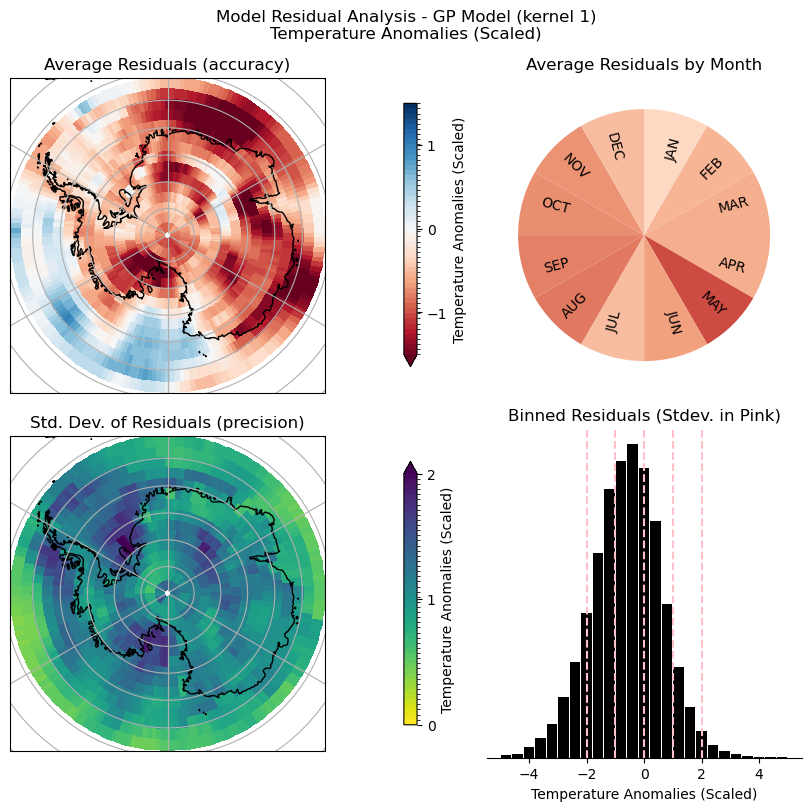

In [52]:
# Kernel 1

resid_plot_file = output_file_prefix_k1 + "_resid_plots.png"

Postprocessing.utils.generate_residual_plots(
    dataset=gp_preds_ds_k1, 
    variable='resid_scaled_deseas_tmp2m', 
    label='Temperature Anomalies (Scaled)', 
    model_name='GP Model (kernel 1)',
    out_file=output_dir + resid_plot_file
)

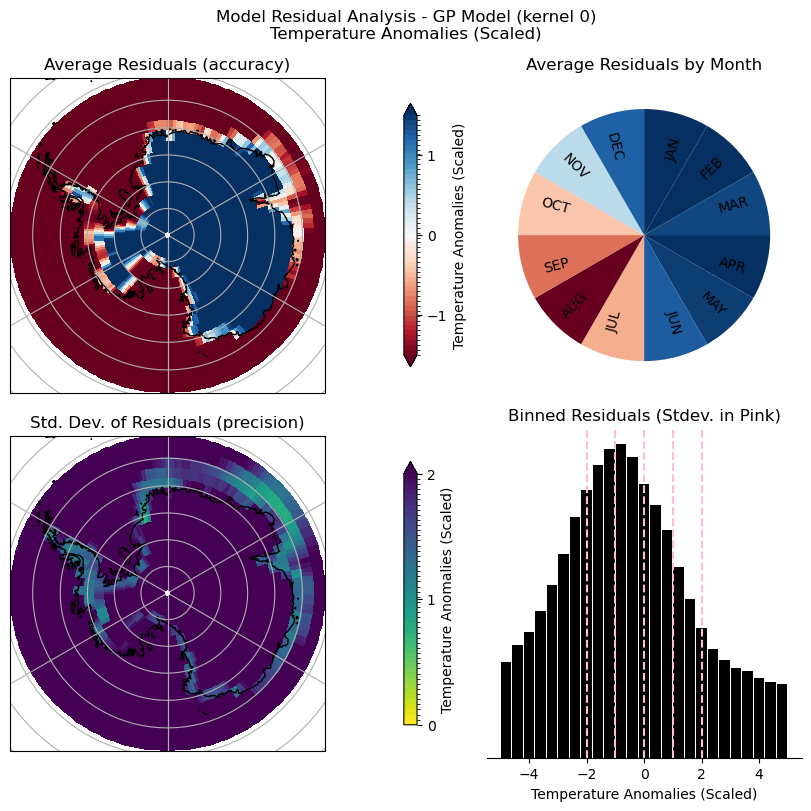

In [53]:
# Kernel 0

resid_plot_file = output_file_prefix_k0 + "_resid_plots.png"

Postprocessing.utils.generate_residual_plots(
    dataset=gp_preds_ds_k0, 
    variable='resid_scaled_deseas_tmp2m', 
    label='Temperature Anomalies (Scaled)', 
    model_name='GP Model (kernel 0)',
    out_file=output_dir + resid_plot_file
)

#### Time-series Plots of Predictions

The following code uses the `generate_time_series_plots()` method from `Postprocessing.utils` to create time series plots of GP model predictions vs. actual values. 

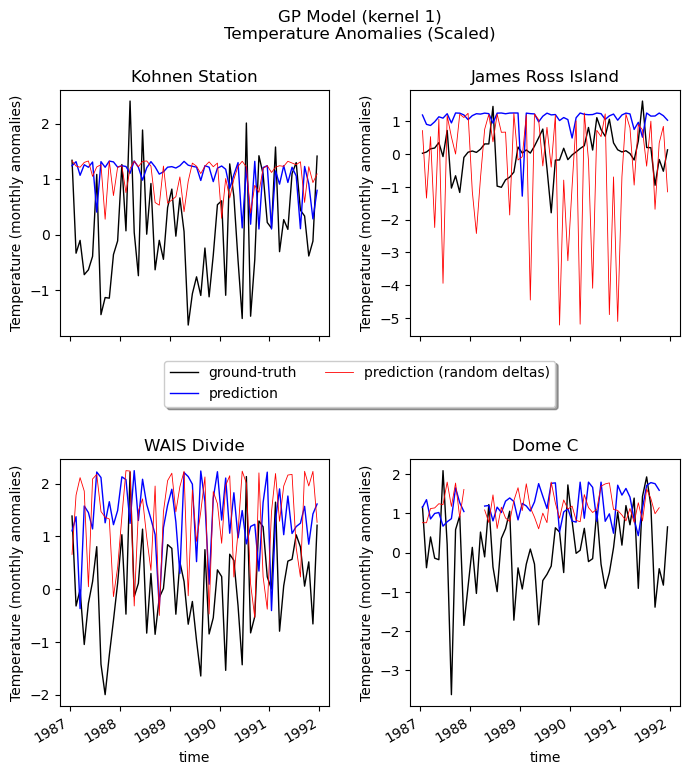

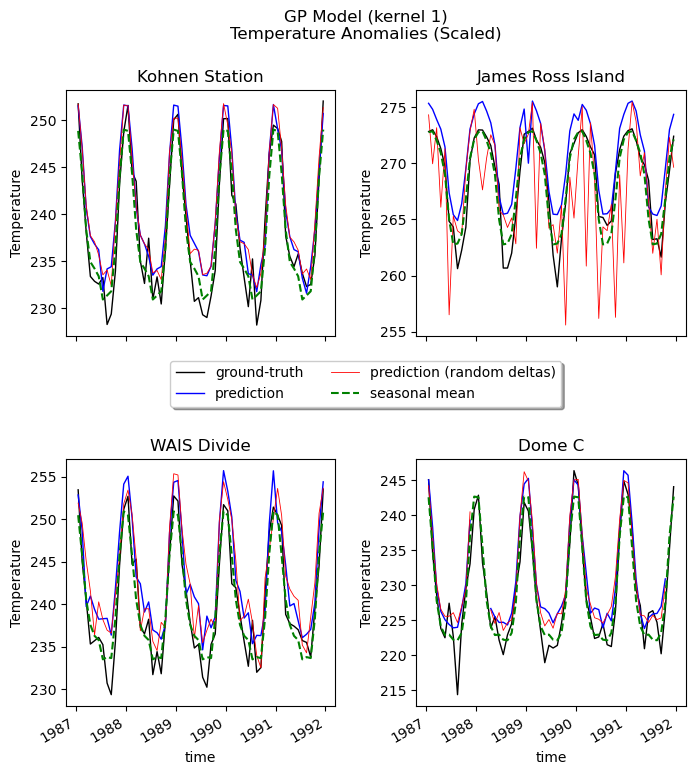

In [54]:
# Kernel 1

time_series_plot_file = output_file_prefix_k1 + "_time_series_plots_scaled_deseas.png"
Postprocessing.utils.generate_time_series_plots(
    dataset=gp_preds_ds_k1, 
    output_var="tmp2m", 
    output_scale='scaled_deseas_',
    num_years=5,
    label='Temperature Anomalies (Scaled)', 
    model_name='GP Model (kernel 1)',
    include_random_deltas=True,
    out_file=output_dir + time_series_plot_file
)

time_series_plot_file = output_file_prefix_k1 + "_time_series_plots_original.png"
Postprocessing.utils.generate_time_series_plots(
    dataset=gp_preds_ds_k1, 
    output_var="tmp2m", 
    output_scale='original',
    num_years=5,
    label='Temperature Anomalies (Scaled)', 
    model_name='GP Model (kernel 1)',
    include_random_deltas=True,
    out_file=output_dir + time_series_plot_file
)

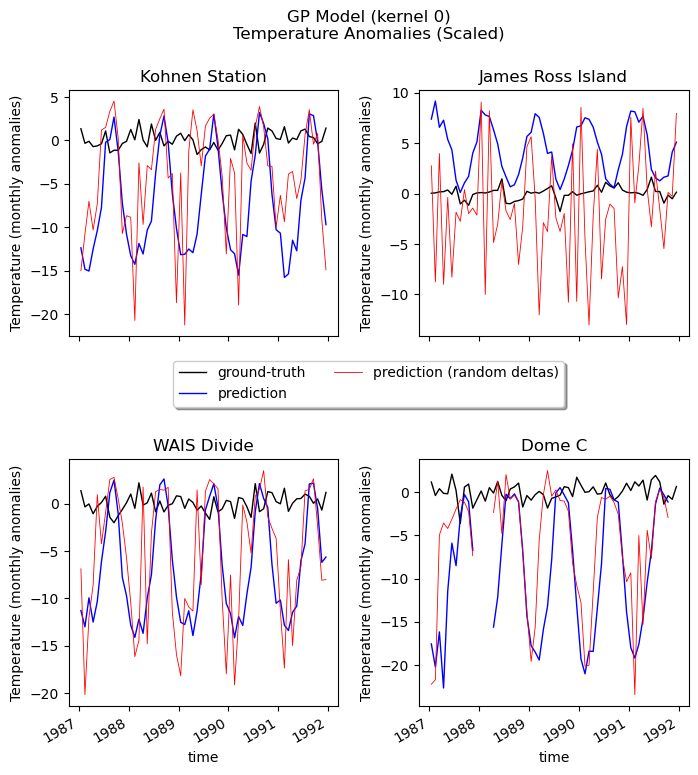

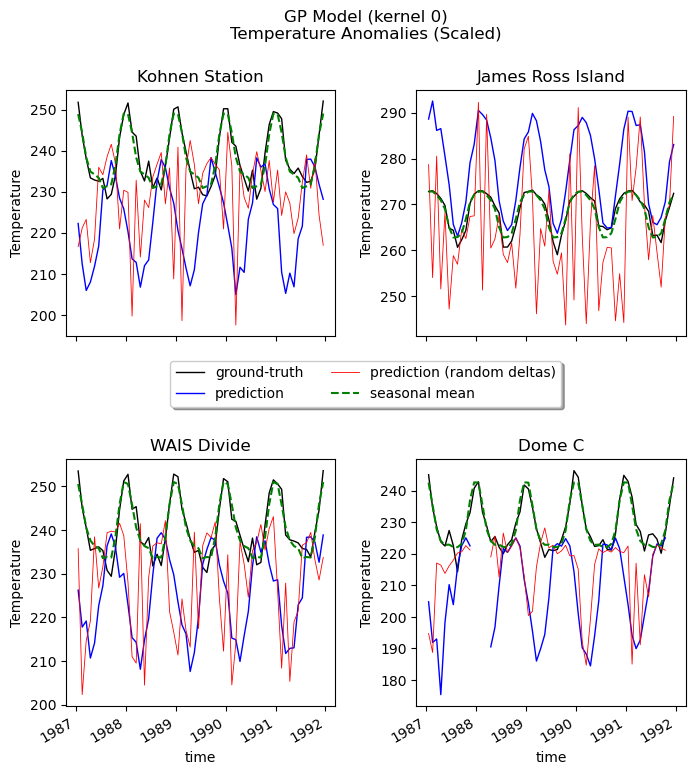

In [55]:
# Kernel 0

time_series_plot_file = output_file_prefix_k0 + "_time_series_plots_scaled_deseas.png"
Postprocessing.utils.generate_time_series_plots(
    dataset=gp_preds_ds_k0, 
    output_var="tmp2m", 
    output_scale='scaled_deseas_',
    num_years=5,
    label='Temperature Anomalies (Scaled)', 
    model_name='GP Model (kernel 0)',
    include_random_deltas=True,
    out_file=output_dir + time_series_plot_file
)

time_series_plot_file = output_file_prefix_k0 + "_time_series_plots_original.png"
Postprocessing.utils.generate_time_series_plots(
    dataset=gp_preds_ds_k0, 
    output_var="tmp2m", 
    output_scale='original',
    num_years=5,
    label='Temperature Anomalies (Scaled)', 
    model_name='GP Model (kernel 0)',
    include_random_deltas=True,
    out_file=output_dir + time_series_plot_file
)

## References 



TODO